# 株式保有戦略の比較デモ

In [1]:
# ライブラリのインポート
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta

In [2]:
# ベンチマークとなるインデックス銘柄の指定
ticker = '^N225'
data = yf.download(ticker, start='2020-01-01', end='2024-07-30')
data.index = pd.to_datetime(data.index)

[*********************100%%**********************]  1 of 1 completed


In [3]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-07-23,39864.089844,39927.890625,39519.910156,39594.390625,39594.390625,88300000
2024-07-24,39336.738281,39643.269531,39096.500000,39154.851562,39154.851562,110300000
2024-07-25,38524.199219,38557.789062,37825.578125,37869.511719,37869.511719,143000000
2024-07-26,37792.871094,38105.960938,37611.191406,37667.410156,37667.410156,124000000
2024-07-29,38139.121094,38719.699219,38010.011719,38468.628906,38468.628906,107300000


In [4]:
# テクニカル指標の計算
fast_MA_period = 50
slow_MA_period = 200
adx_period = 14
adx_threashold = 25
data[f'MA_fast'] = data['Adj Close'].rolling(window=fast_MA_period).mean()
data[f'MA_slow'] = data['Adj Close'].rolling(window=slow_MA_period).mean()
data['ADX'] = data.ta.adx(length=adx_period)[f'ADX_{adx_period}']
data.dropna(inplace=True)
data.tail()

,Open,High,Low,Close,Adj Close,Volume,MA_fast,MA_slow,ADX
Date,,,,,,,,,
2024-07-23,39864.089844,39927.890625,39519.910156,39594.390625,39594.390625,88300000,39406.804531,36589.682539,24.267224
2024-07-24,39336.738281,39643.269531,39096.500000,39154.851562,39154.851562,110300000,39422.780391,36626.094199,23.844687
2024-07-25,38524.199219,38557.789062,37825.578125,37869.511719,37869.511719,143000000,39412.456016,36656.153662,24.808913
2024-07-26,37792.871094,38105.960938,37611.191406,37667.410156,37667.410156,124000000,39387.398984,36685.691309,25.885715
2024-07-29,38139.121094,38719.699219,38010.011719,38468.628906,38468.628906,107300000,39381.023984,36721.844756,25.775464


In [5]:
# シグナル系列（1=買い,0=静観,-1=売り）の生成
def identify_trend(row):
    if row['ADX'] > adx_threashold and row['MA_fast'] > row['MA_slow']:
        return 1
    elif row['ADX'] > adx_threashold and row['MA_fast'] < row['MA_slow']:
        return -1
    else:
        return 0
data['Signal'] = data.apply(identify_trend, axis=1)
#count values per position
data['Signal'].value_counts()

Signal
 0    634
 1    211
-1     73
Name: count, dtype: int64

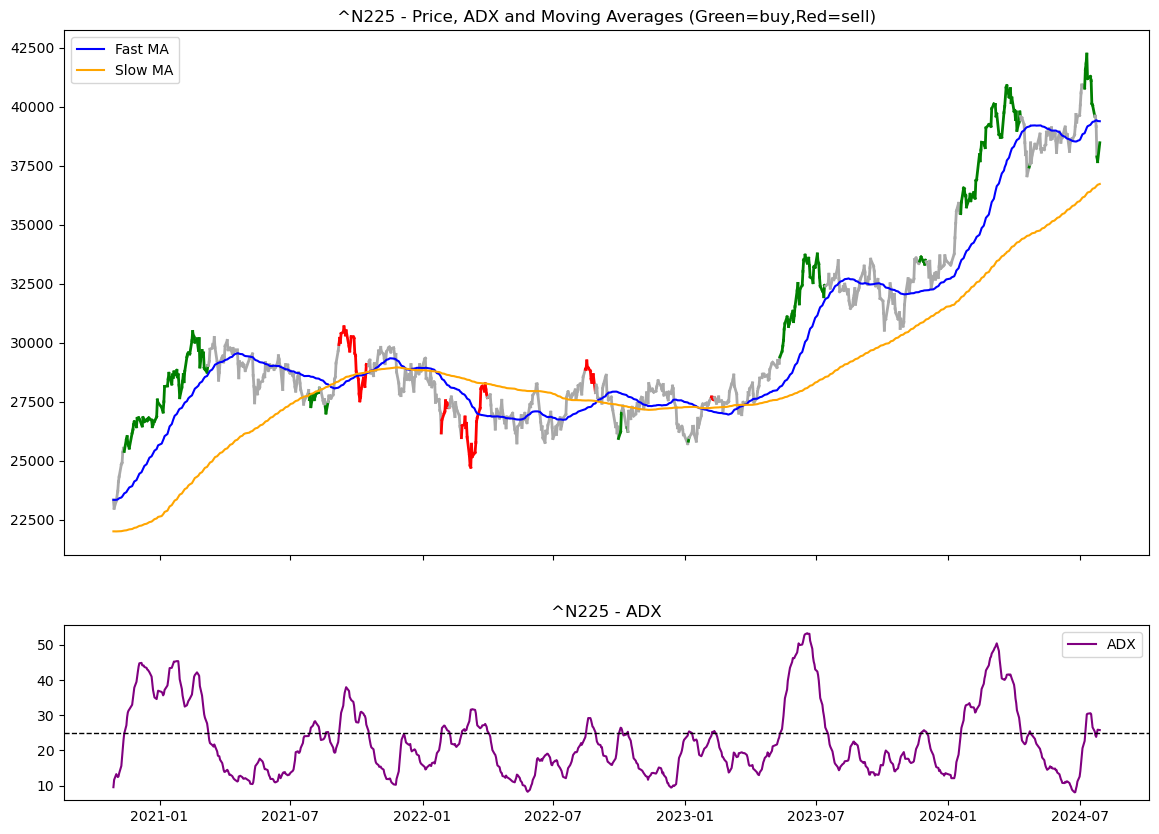

In [6]:
# シグナル、移動平均、ADXのプロット
df = data.copy()
# Plotting with adjusted subplot heights
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, 
                               gridspec_kw={'height_ratios': [3, 1]})
# Plotting the close price with the color corresponding to the trend
for i in range(1, len(df)):
    ax1.plot(df.index[i-1:i+1], df['Close'].iloc[i-1:i+1], 
             color='green' if df['Signal'].iloc[i] == 1 else 
                   ('red' if df['Signal'].iloc[i] == -1 else 'darkgrey'), linewidth=2)
# Plot the Moving Averages
ax1.plot(df['MA_fast'], label='Fast MA', color='blue')
ax1.plot(df['MA_slow'], label='Slow MA', color='orange')
ax1.set_title(f'{ticker} - Price, ADX and Moving Averages (Green=buy,Red=sell)')
ax1.legend(loc='best')
# Plot ADX on the second subplot (smaller height)
ax2.plot(df.index, df['ADX'], label='ADX', color='purple')
ax2.axhline(25, color='black', linestyle='--', linewidth=1)  # Add a horizontal line at ADX=25
ax2.set_title(f'{ticker} - ADX')
ax2.legend(loc='best')
plt.show()

In [7]:
# 日々のリターンの計算（売買戦略）
def calculate_returns(df_for_returns, col_for_returns, col_for_signal):
    df_for_returns['Daily_Returns'] = df_for_returns[col_for_returns].pct_change()
    df_for_returns['Returns'] = df_for_returns['Daily_Returns'] * df_for_returns[col_for_signal].shift(1)
    df_for_returns['Returns'] = df_for_returns['Returns'].fillna(0)
    df_for_returns['Equity_Curve'] = 100 * (1 + df_for_returns['Returns']).cumprod()
    return df_for_returns
data = calculate_returns(data, 'Adj Close', 'Signal')

In [8]:
# 日々のリターンの計算（インデックス運用）
def calculate_benchmark_returns(df_for_returns, col_for_returns):
    df_for_returns['Benchmark_Returns'] = df_for_returns[col_for_returns].pct_change()
    df_for_returns['Benchmark_Returns'] = df_for_returns['Benchmark_Returns'].fillna(0)
    df_for_returns['Benchmark_Equity_Curve'] = 100 * (1 + df_for_returns['Benchmark_Returns']).cumprod()
    return df_for_returns
data  = calculate_benchmark_returns(data, 'Adj Close')

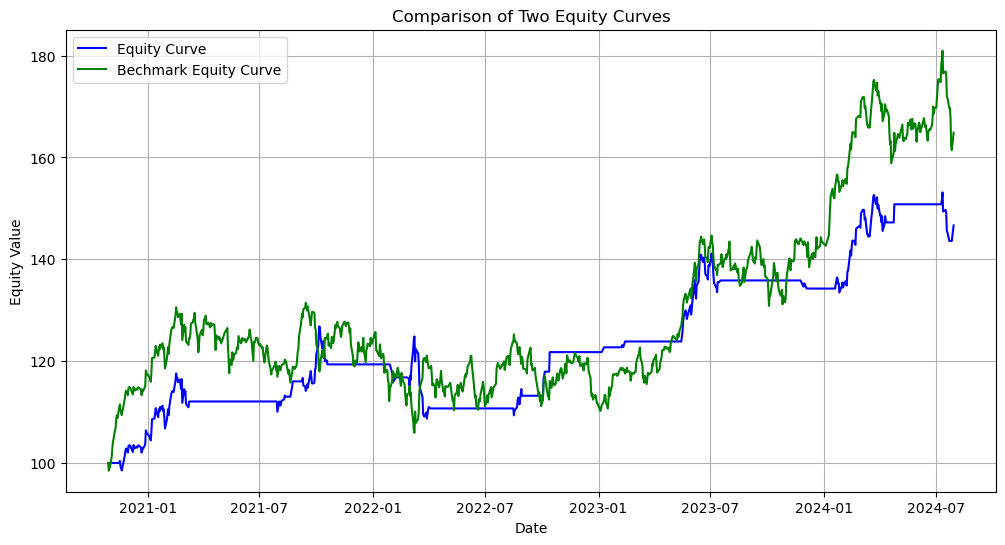

In [20]:
# 2つのエクイティカーブの描画による比較
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Equity_Curve'], label='Equity Curve', color='blue')
plt.plot(data.index, data['Benchmark_Equity_Curve'], label='Bechmark Equity Curve', color='green')
plt.xlabel('Date')
plt.ylabel('Equity Value')
plt.title('Comparison of Two Equity Curves')
plt.legend()
plt.grid()
plt.show()

In [10]:
time_in_market = data['Signal'][data['Signal'] != 0].count() / len(data)
print(f"Strategy Time Exposure: {time_in_market * 100:.2f}%")

Strategy Time Exposure: 30.94%


In [11]:
# Set up the annual rates dictionary
# 日本のMRFの利回りに置換え
annual_rates = {2020:0.0001,2021:0.0001,2022:0.0001,2023:0.0005,2024:0.0015}
# Create a new column that holds the difference in days between the current row and the previous one
data['Days_Difference'] = data.index.to_series().diff().dt.days
data['Days_Difference'] = data['Days_Difference'].fillna(1)
# Extract the year from the index and create a new column for the year
data['Year'] = data.index.year
# Calculate daily rates
daily_rates= {year: (1 + rate) ** (1 / 365) - 1 for year, rate in annual_rates.items()}
# Map the daily rates to the corresponding year and create a new column for the daily rate
data['Daily_Rate_Returns'] = data['Year'].map(daily_rates) * data['Days_Difference']
# Calculate the days that there is an open position
data['Open_Position'] = data['Signal'].shift(1)
# data['Open_Position'] = data['Signal'].shift(1)
data['Open_Position'] = data['Open_Position'].fillna(0)
data['Returns_Combined'] = data.apply(lambda row: row['Open_Position'] * row['Daily_Returns'] if row['Open_Position'] != 0 else row['Daily_Rate_Returns'], axis=1)
data['Returns_Combined'] = data['Returns_Combined'].fillna(0)
data['Equity_Curve_including_interest'] = 100 * (1 + data['Returns_Combined']).cumprod()

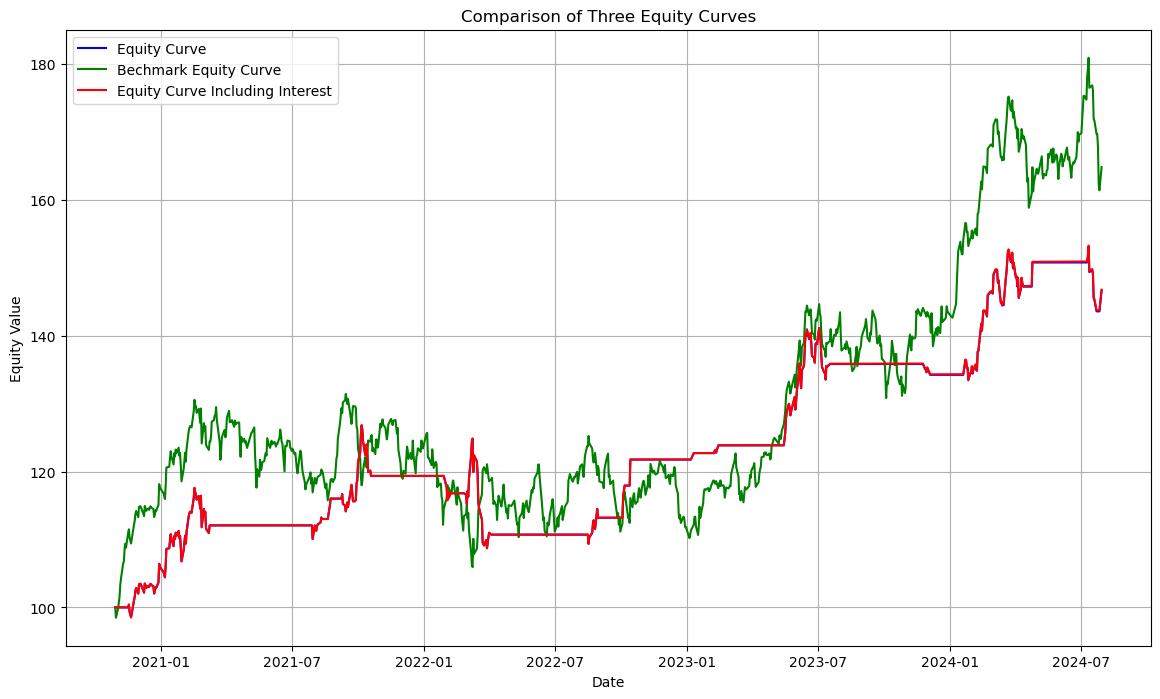

In [12]:
# 3つのエクイティカーブの描画による比較（日本では利息を考慮してもほとんど変わらない）
plt.figure(figsize=(14, 8))
# Plot both equity curves
plt.plot(data.index, data['Equity_Curve'], label='Equity Curve', color='blue')
plt.plot(data.index, data['Benchmark_Equity_Curve'], label='Bechmark Equity Curve', color='green')
plt.plot(data.index, data['Equity_Curve_including_interest'], label='Equity Curve Including Interest', color='red')
# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Equity Value')
plt.title('Comparison of Three Equity Curves')
plt.legend()
# Show the plot
plt.grid()
plt.show()

In [13]:
# 戦略別の投資指標のまとめ
compare_table = pd.DataFrame(columns=['Strategy','Market','Combined'])

In [14]:
def max_drawdown(cumulative_returns):
    roll_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / roll_max - 1.0
    max_drawdown = drawdown.cummin()
    return max_drawdown.min()
compare_table.loc['MaxDrawdown','Strategy'] = max_drawdown(data['Equity_Curve']) * 100
compare_table.loc['MaxDrawdown','Market'] = max_drawdown(data['Benchmark_Equity_Curve']) * 100
compare_table.loc['MaxDrawdown','Combined'] = max_drawdown(data['Equity_Curve_including_interest']) * 100

In [15]:
# Sharpe Ratio
annual_return_strategy = data['Returns'].mean() * 252
annual_volatility_strategy = data['Returns'].std() * np.sqrt(252)
annual_return_market = data['Benchmark_Returns'].mean() * 252
annual_volatility_market = data['Benchmark_Returns'].std() * np.sqrt(252)
annual_return_market_combined = data['Returns_Combined'].mean() * 252
annual_volatility_market_combined = data['Returns_Combined'].std() * np.sqrt(252)
compare_table.loc['SharpeRatio','Strategy'] = annual_return_strategy / annual_volatility_strategy
compare_table.loc['SharpeRatio','Market'] = annual_return_market / annual_volatility_market
compare_table.loc['SharpeRatio','Combined'] = annual_return_market_combined / annual_volatility_market_combined

In [16]:
# Downside Volatility
downside_volatility_strategy = data[data['Returns'] < 0]['Returns'].std() * np.sqrt(252)
downside_volatility_market = data[data['Benchmark_Returns'] < 0]['Benchmark_Returns'].std() * np.sqrt(252)
downside_volatility_market_combined = data[data['Benchmark_Returns'] < 0]['Benchmark_Returns'].std() * np.sqrt(252)
compare_table.loc['SortinoRatio','Strategy'] = annual_return_strategy / downside_volatility_strategy
compare_table.loc['SortinoRatio','Market'] = annual_return_market / downside_volatility_market
compare_table.loc['SortinoRatio','Combined'] = annual_return_market_combined / downside_volatility_market_combined

In [17]:
# Function to calculate volatility (standard deviation of returns)
def volatility(cumulative_returns):
    returns = cumulative_returns.pct_change().dropna()
    return returns.std()
# Assuming `data` is your DataFrame containing multiple equity curves
compare_table.loc['Volatility','Strategy'] = volatility(data['Equity_Curve'])
compare_table.loc['Volatility','Market'] = volatility(data['Benchmark_Equity_Curve'])
compare_table.loc['Volatility','Combined'] = volatility(data['Equity_Curve_including_interest'])

In [18]:
# まとめ表の作成と表示
result_table = compare_table.T
result_table['MaxDrawdown'] = result_table['MaxDrawdown'].apply(lambda x: '{:.2f}%'.format(x))
result_table['SharpeRatio'] = result_table['SharpeRatio'].apply(lambda x: '{:.2f}'.format(x))
result_table['SortinoRatio'] = result_table['SortinoRatio'].apply(lambda x: '{:.2f}'.format(x))
result_table['Volatility'] = result_table['Volatility'].apply(lambda x: '{:.4f}'.format(x))
result_table

,MaxDrawdown,SharpeRatio,SortinoRatio,Volatility
Strategy,-14.28%,1.05,0.91,0.0066
Market,-19.41%,0.84,1.32,0.0115
Combined,-14.28%,1.05,0.95,0.0066
